In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [86]:
# Extract the last texts with z-scores from the SemStamp attack

def breakup_attacks(df):
    # Break the DF up into smaller DFs
    dfs = []
    current_df = None

    # Iterate over the rows and split on step_num resets
    for i, row in df.iterrows():
        # Check if the step_num resets to -1, indicating a new sequence
        if row['mutation_num'] == -1:
            if current_df is not None and not current_df.empty:
                dfs.append(current_df.reset_index(drop=True))  # Save the current increasing DF
            current_df = pd.DataFrame([row])  # Start a new DataFrame with the reset row
        else:
            # Append the row to the current DataFrame
            current_df = pd.concat([current_df, pd.DataFrame([row])])

    # Add the last DataFrame if it exists and is non-empty
    if current_df is not None and not current_df.empty:
        dfs.append(current_df.reset_index(drop=True))
    
    return dfs

def extract_last_mutated_text(df: pd.DataFrame) -> str:
    # Filter the rows where quality_preserved is True
    filtered_df = df[df['quality_preserved'] == True]
    
    # Check if any row exists
    if not filtered_df.empty:
        # Extract the mutated_text from the last valid row
        return filtered_df.iloc[-1]['mutated_text']
    else:
        return None  # Return None if no row matches

def extract_zscore(df: pd.DataFrame) -> str:    
    # Check if any row exists
    if not df.empty:
        # Extract the mutated_text from the last valid row
        return df.iloc[-1]['watermark_score']
    else:
        return None  # Return None if no row matches

df = pd.read_csv('/data2/borito1907/impossibility-watermark/attack_traces/DiffOracle_SemStampWatermarker_SentenceMutator_n-steps=200_attack_results_annotated.csv')
# df = pd.read_csv('/data2/borito1907/impossibility-watermark/attack_traces/DiffOracle_SemStampWatermarker_SpanMutator_n-steps=200_attack_results_annotated.csv')
# df = pd.read_csv('/data2/borito1907/impossibility-watermark/attack_traces/DiffOracle_SemStampWatermarker_Document1StepMutator_n-steps=200_attack_results_annotated.csv')

dfs = breakup_attacks(df)
dfs = [df for df in dfs if len(df) >= 5]
dfs = [df for df in dfs if df[df['quality_preserved'] == True].shape[0] > 10]

prompts = [df.iloc[-1]['prompt'] for df in dfs]
og_texts = [df.iloc[1]['current_text'] for df in dfs]
mutated_texts = [extract_last_mutated_text(df) for df in dfs]
zscores = [extract_zscore(df) for df in dfs]

In [91]:
df = pd.read_csv('/data2/borito1907/impossibility-watermark/data/WQE_semstamp/dev.csv')
unattacked_zscores = df['zscore']

In [92]:
unwatermarked_df = pd.read_csv('/data2/borito1907/impossibility-watermark/unwatermarked_scores/semstamp_detect_unwatermarked.csv')
unwatermarked_zscores = unwatermarked_df['watermark_score']

In [102]:
print("Length of zscores list:", len(zscores))
print("Length of unwatermarked_zscores list:", len(unwatermarked_zscores))

Length of zscores list: 90
Length of unwatermarked_zscores list: 90


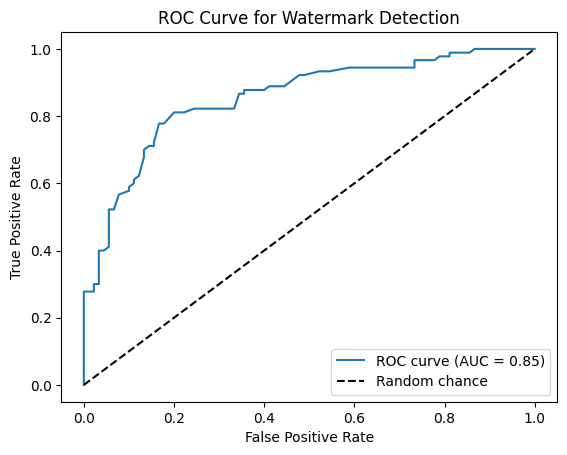

AUC: 0.85


In [101]:
unwatermarked_zscores = unwatermarked_zscores[:len(zscores)]

all_scores = np.concatenate((zscores, unwatermarked_zscores))

# Create labels: 1 for watermarked, 0 for unwatermarked
labels = [1] * len(zscores) + [0] * len(unwatermarked_zscores)

# Compute the AUC score
auc = roc_auc_score(labels, all_scores)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_scores)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Watermark Detection')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f"AUC: {auc:.2f}")

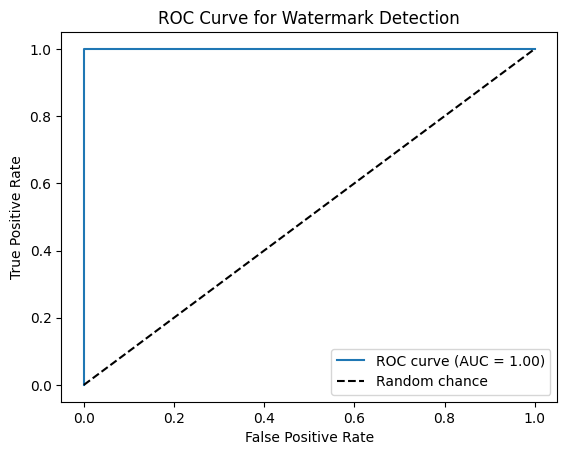

AUC: 1.00


In [95]:
all_scores = np.concatenate((unattacked_zscores, unwatermarked_zscores))

# Create labels: 1 for watermarked, 0 for unwatermarked
labels = [1] * len(unattacked_zscores) + [0] * len(unwatermarked_zscores)

# Compute the AUC score
auc = roc_auc_score(labels, all_scores)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_scores)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Watermark Detection')
plt.legend(loc="lower right")
plt.show()

# Print AUC
print(f"AUC: {auc:.2f}")

In [99]:
np.mean(zscores)

1.0694165644977696

In [97]:
np.mean(unwatermarked_zscores)

-0.7281950363003581